# Stime di Crescita

> Max Pierini, Alessio Pamovio

Leggi [qui](https://maxpierini.it/ncov/italy-regions-exp-new.pdf) per il metodo utilizzato.

In [1]:
import copy
import json
import requests
import datetime as dt

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

#import plotly.graph_objects as go
#import plotly.offline as pyo

from scipy.interpolate import interp1d
import scipy.stats as sps

import pyjags
import arviz as az

from IPython.display import clear_output, HTML, Markdown

#pyo.init_notebook_mode()

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
     usecols=['data', 'denominazione_regione', 'totale_casi', 'deceduti'],
     parse_dates=['data'],
     index_col=['denominazione_regione', 'data'],
     squeeze=True).sort_index()

countries = df.index.get_level_values("denominazione_regione").unique().sort_values()
days = df.index.get_level_values("data").unique()

In [3]:
_ = """print("FIRST ENTRY DATE: {}".format(
    days[0]
    )
)
print("LAST  ENTRY DATE: {}".format(
    days[-1]
    )
)
period = (days[-1] - days[0]).days

print("COVERAGE: {} days".format(period))
print("CURRENT DATE IS: {}".format(dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))"""

In [4]:
with open("priors.npy", "rb") as f:
    bartlett_samples = np.load(f)

In [5]:
def slope(x, y0, yz):
    alpha = (yz - y0) / (x.size - 1)
    return alpha

def exp_unif(x, beta, y0, yz):
    with np.errstate(all='ignore'):
        y = np.nan_to_num((np.exp(beta * x) - 1)/(np.exp(beta) - 1))
        y = y * (yz - y0) + y0
        
    alpha = slope(x, y0, yz)

    return (y, alpha)

window = 14
x = np.linspace(0, 1, window)

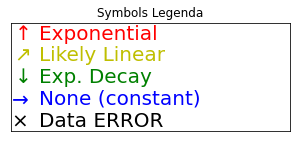

In [6]:
fig, ax = plt.subplots(figsize=(5,2))
ax.text(0, .1, r"$\times$", color="k", fontsize=20, ha='left', va='center')
ax.text(0, .3, r"$\to$", color="b", fontsize=20, ha='left', va='center')
ax.text(0, .5, r"$\downarrow$", color="g", fontsize=20, ha='left', va='center')
ax.text(0, .7, r"$\nearrow$", color="y", fontsize=20, ha='left', va='center')
ax.text(0, .9, r"$\uparrow$", color="r", fontsize=20, ha='left', va='center')

ax.text(.1, .1, "Data ERROR", color="k", fontsize=20, ha='left', va='center')
ax.text(.1, .3, "None (constant)", color="b", fontsize=20, ha='left', va='center')
ax.text(.1, .5, "Exp. Decay", color="g", fontsize=20, ha='left', va='center')
ax.text(.1, .7, "Likely Linear", color="y", fontsize=20, ha='left', va='center')
ax.text(.1, .9, "Exponential", color="r", fontsize=20, ha='left', va='center')

ax.set_xticks([])
ax.set_yticks([])

ax.set_title("Symbols Legenda")
fig.set_facecolor('w')
fig.set_facecolor('w'); plt.show();
plt.close(fig="all")

# deceduti

## beta

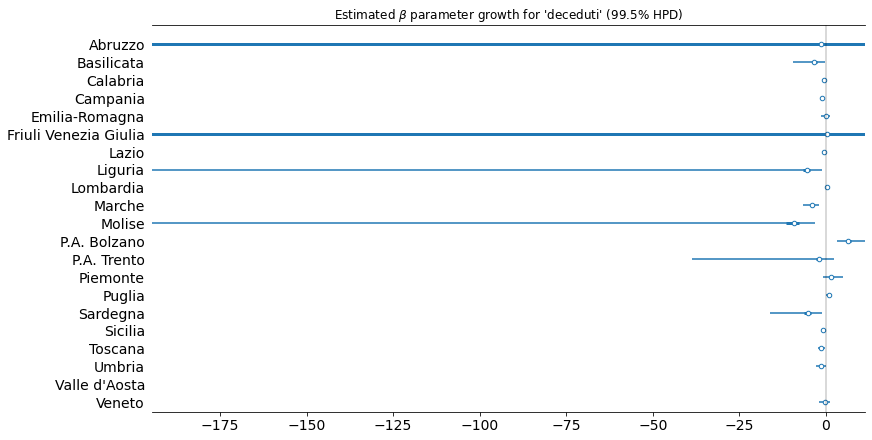

,mean,sd,hdi_0.5%,hdi_99.5%
denominazione_regione,,,,
Abruzzo,-2.113,279.960,-486.714,476.578
Basilicata,-3.490,1.358,-8.078,-0.401
Calabria,-0.608,0.183,-1.106,-0.099
Campania,-1.075,0.134,-1.454,-0.709
Emilia-Romagna,-0.087,0.408,-1.261,1.012
Friuli Venezia Giulia,0.722,281.208,-478.304,485.344
Lazio,-0.608,0.153,-1.036,-0.191
Liguria,-16.978,40.407,-194.679,-1.141
Lombardia,0.229,0.138,-0.147,0.608


## fitted

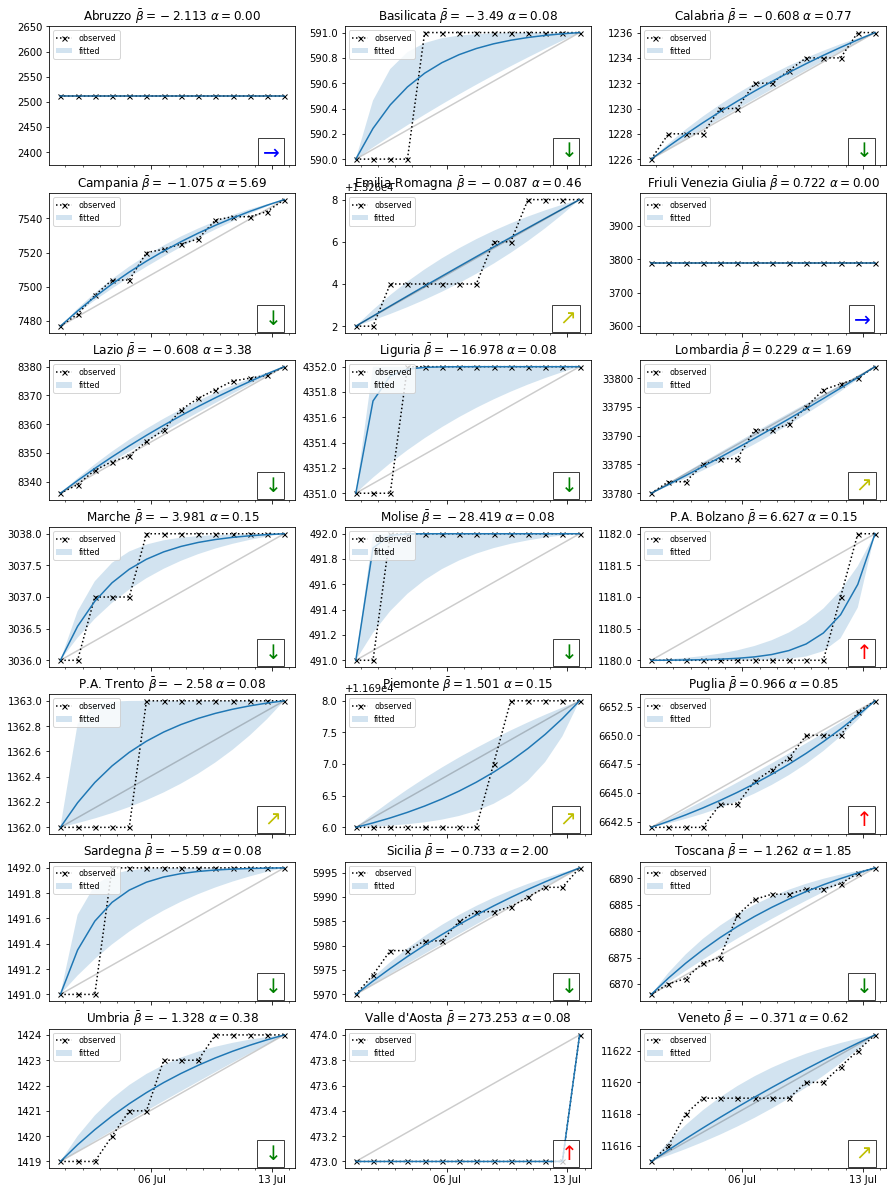

# totale_casi

## beta

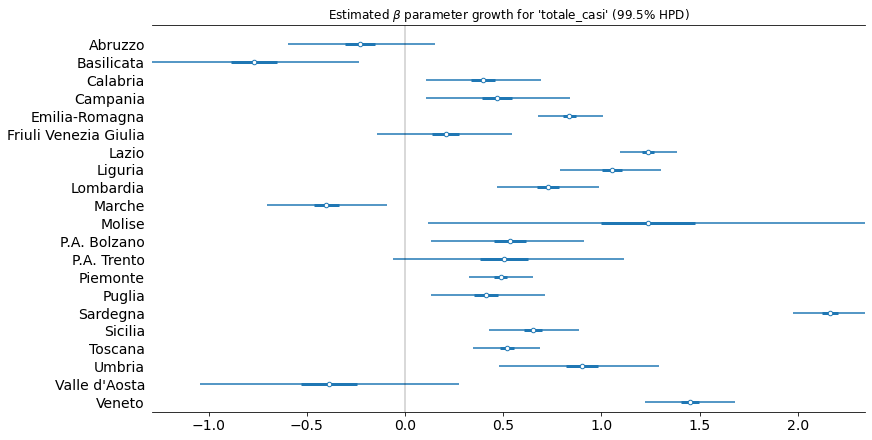

,mean,sd,hdi_0.5%,hdi_99.5%
denominazione_regione,,,,
Abruzzo,-0.228,0.121,-0.567,0.098
Basilicata,-0.773,0.183,-1.289,-0.282
Calabria,0.397,0.097,0.130,0.653
Campania,0.467,0.119,0.149,0.807
Emilia-Romagna,0.836,0.053,0.693,0.986
Friuli Venezia Giulia,0.207,0.111,-0.099,0.513
Lazio,1.236,0.046,1.109,1.365
Liguria,1.053,0.083,0.825,1.285
Lombardia,0.728,0.085,0.491,0.965


## fitted

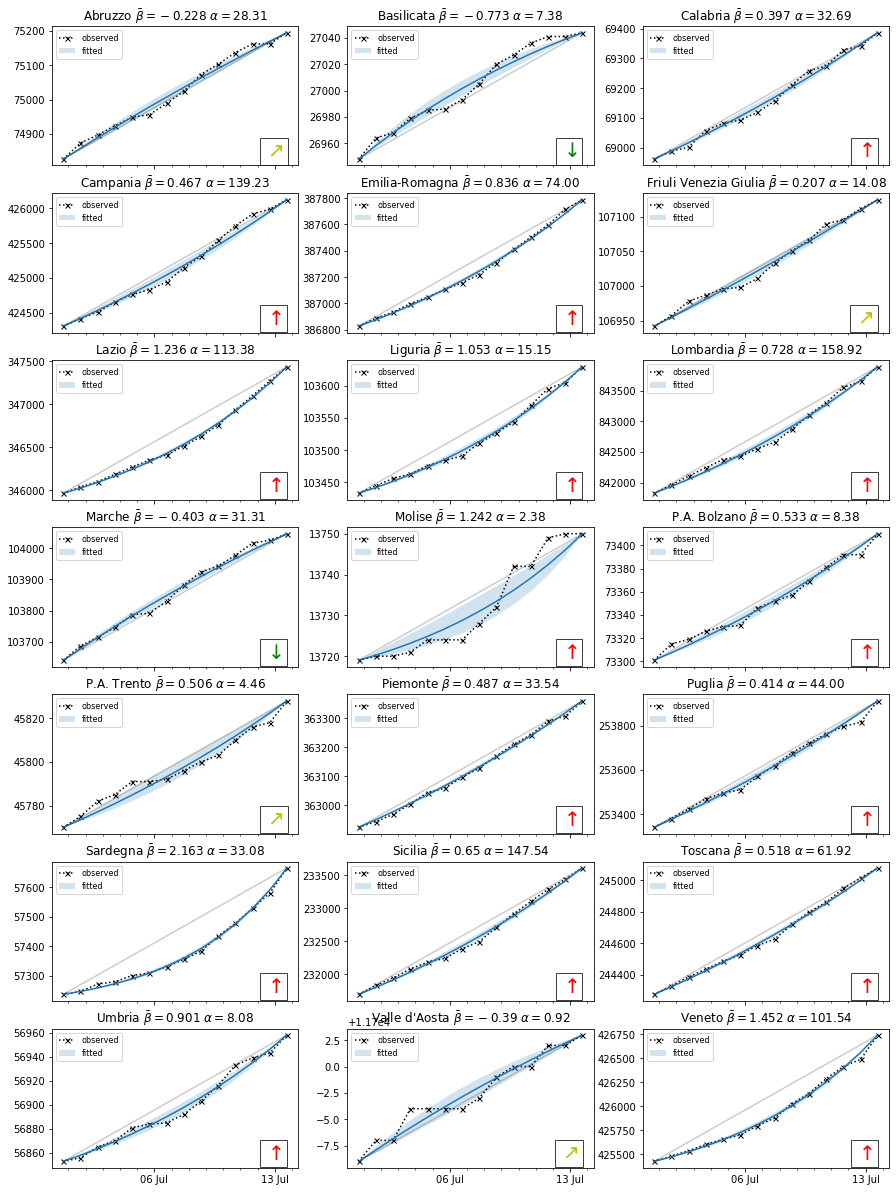

# Sommario

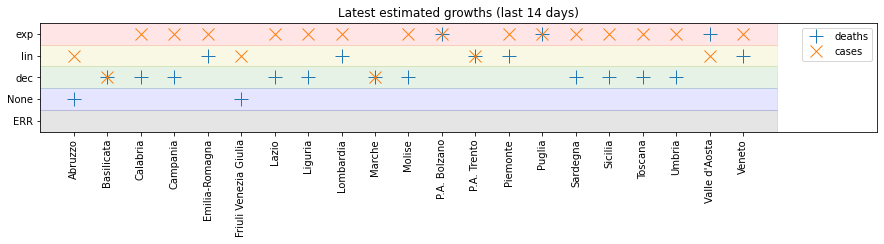

Growths summary:

,ERR,None,dec,lin,exp
deaths,0,2,11,5,3
cases,0,0,2,4,15



Per il totale cumulativo casi

- 15 regioni 71.43% è verosimile una crescita esponenziale
- 4 regioni 19.05% è verosimile una crescita lineare
- 2 regioni 9.52% è verosimile un decadimento esponenziale
- 0 regioni 0.00% sono verosimilmente costanti

Per il totale cumulativo decessi:

- 3 regions 14.29% è verosimile una crescita esponenziale
- 5 regions 23.81% è verosimile una crescita lineare
- 11 regions 52.38% è verosimile un decadimento esponenziale
- 2 regions 9.52% sono verosimilmente costanti


In 71% regioni, i casei
crescono esponenzialmente e nel 10%
la situazione è verosimilmente risolta o in via di risoluzione.

In 62% regioni
i decessi non stanno crescendo o decadendo esponenzialmente e 14%
mostrano invece una crescita esponenziale.

La situazione nelle regioni in crescita lineare (19% per i casi e
24% per i decessi) non è seria ma nemmeno in verosimile risoluzione.


In [7]:
beta_lim = 487

modelString = f"""
model {{
  for ( r in 1:R ) {{
    # inverse gamma variance
    tau[r] ~ dgamma( 0.001 , 0.001 )
    sigma[r] <- 1 / sqrt( tau[r] )
    # beta priors
    beta[r] ~ dunif( -{beta_lim} , {beta_lim} )
    
    for ( t in 1:W ) {{
      # define lim(beta->0)
      H[r,t] <- ( exp( beta[r] * x[t] ) - 1 )
      f[r,t] <- ifelse( nu[r] == 1 , x[t] , H[r,t] / nu[r] )
      # expected and observed
      E[r,t] <- f[r,t] * (yw[r] - y1[r]) + y1[r]
      y[r,t] ~ dnorm( E[r,t] , tau[r] )
    }}
    
    # define lim(beta->0)
    nu[r] <- ifelse( exp( beta[r] ) - 1 == 0 , 1 , exp( beta[r] ) - 1 )
  }}
}}
"""

w_min = -window-1
w_max = -1

growth = {}

for what in df.columns:
    display(Markdown(f"# {what}"))
    growth.update({
        (what, 'x'): {},
        (what, 'growth'): {},
        (what, 'beta'): {},
        (what, 'alpha'): {},
    })
    y = np.array([])
    Y = np.array([])
    beta_lims = np.array([])
    for country in countries:
        growth[(what, 'x')].update({country: None})
        growth[(what, 'growth')].update({country: None})
        growth[(what, 'beta')].update({country: None})
        growth[(what, 'alpha')].update({country: None})
        T = df.loc[country][what][w_min:w_max].values
        _T = copy.deepcopy(T)
        if _T[0] > _T[-1]:
            _T = _T[0] * np.ones(window)
        if not y.size:
            Y = copy.deepcopy(T)
            y = copy.deepcopy(_T)
        else:
            Y = np.vstack([Y, T])
            y = np.vstack([y, _T])
        
    model_data = {
        "R": countries.size,
        "W": window,
        "x": x,
        "y": y,
        "y1": y[:,0],
        "yw": y[:,window-1],
    }
    jags_posterior_model = pyjags.Model(
        code=modelString, 
        data=model_data, 
        chains=4, 
        adapt=2000,
        progress_bar=False
    )

    #_ = jags_posterior_model.sample(2000, vars=["beta", "sigma"])
    
    jags_posterior_samples = jags_posterior_model.sample(8000, vars=["beta", "sigma"])
    
    pyjags_data = az.from_pyjags(jags_posterior_samples)

    summary = az.summary(pyjags_data, var_names="^beta", filter_vars="regex", hdi_prob=.99, kind="stats")
    summary_diag = az.summary(pyjags_data, var_names="^beta", filter_vars="regex", hdi_prob=.99, kind="diagnostics")
    
    sigma_smry = az.summary(pyjags_data, var_names="^sigma", filter_vars="regex", hdi_prob=.99, kind="stats")
    sigma_smry_diag = az.summary(pyjags_data, var_names="^sigma", filter_vars="regex", hdi_prob=.99, kind="diagnostics")
    
    #display(Markdown(f"### sigma"))
    
    _ = """for i, par in enumerate(sigma_smry.index):
        axs = az.plot_trace(
            pyjags_data.posterior.sigma[:,:,i],
            figsize=(20,2)
        )
        for j, ax in enumerate(axs):
            ax[j].set_title(f"sigma\n{countries[i]}")
        fig.set_facecolor('w'); plt.show();
        plt.close(fig="all")
    
    axs = az.plot_density(
        pyjags_data.posterior.sigma,
        hdi_prob=.995,
        point_estimate="mode",
        figsize=(20,2*7)
    )
    for i, ax in enumerate(axs):
        ax.set_title(f"sigma\n{countries[i]}")
    fig.set_facecolor('w'); plt.show();
    plt.close(fig="all")"""
    
    _ = """ax = az.plot_forest(
        pyjags_data, combined=True,
        var_names="^sigma",
        filter_vars="regex",
        hdi_prob=.995,
        figsize=(12,6),
    )
    ax[0].axvline(0, c="k", alpha=.2)
    ax[0].set_yticklabels(countries[::-1])
    ax[0].set_title(fr"Estimated $\sigma$ for '{what}' (99.5% HPD)")
    fig.set_facecolor('w'); plt.show();
    plt.close(fig="all")
    
    display(HTML(sigma_smry.set_index(countries).to_html()))"""
    #display(Latex(sigma_smry_diag.set_index(countries).to_latex(longtable=True, )))
    
    display(Markdown(f"## beta"))
    
    _ = """for i, par in enumerate(summary.index):
        axs = az.plot_trace(
            pyjags_data.posterior.beta[:,:,i],
            figsize=(20,2)
        )
        for j, ax in enumerate(axs):
            ax[j].set_title(f"beta\n{countries[i]}")
        fig.set_facecolor('w'); plt.show();
        plt.close(fig="all")
    
    axs = az.plot_density(
        pyjags_data.posterior.beta,
        hdi_prob=.995,
        figsize=(20,2*7)
    )
    for i, ax in enumerate(axs):
        ax.set_title(f"beta\n{countries[i]}")
    fig.set_facecolor('w'); plt.show();
    plt.close(fig="all")"""

    beta_smry = summary[(summary["hdi_0.5%"]>-beta_lim*.5) & (summary["hdi_99.5%"]<beta_lim*.5)]
    
    ax = az.plot_forest(
        pyjags_data, combined=True,
        var_names="^beta",
        filter_vars="regex",
        hdi_prob=.995,
        figsize=(12,6),
    )
    ax[0].set_xlim(beta_smry["hdi_0.5%"].min(), beta_smry["hdi_99.5%"].max())
    ax[0].axvline(0, c="k", alpha=.2)
    ax[0].set_yticklabels(countries[::-1])
    ax[0].set_title(fr"Estimated $\beta$ parameter growth for '{what}' (99.5% HPD)")
    fig.set_facecolor('w'); plt.show();
    plt.close(fig="all")
    
    display(HTML(summary.set_index(countries).to_html()))
    #display(Latex(summary_diag.set_index(countries).to_latex(longtable=True, )))
    
    display(Markdown(f"## fitted"))
    fig, ax = plt.subplots(7, 3, figsize=(15, 3*7), sharex=True)
    for par in range(countries.size):
        y1 = Y[par,0]
        yw = Y[par,-1]
        
        mu = summary.loc[f"beta[{par}]"]["mean"]
        lo = summary.loc[f"beta[{par}]"]["hdi_0.5%"]
        hi = summary.loc[f"beta[{par}]"]["hdi_99.5%"]
        sd = summary.loc[f"beta[{par}]"]["sd"]
        
        prmu, alpha = exp_unif(x, mu, y1, yw)
        prlo, _ = exp_unif(x, lo, y1, yw)
        prhi, _ = exp_unif(x, hi, y1, yw)
        
        bartlett_s, bartlett_p = sps.bartlett(
            bartlett_samples, 
            pyjags_data.posterior.beta[0,:,par].values.flatten(),
            pyjags_data.posterior.beta[1,:,par].values.flatten(),
            pyjags_data.posterior.beta[2,:,par].values.flatten(),
            pyjags_data.posterior.beta[3,:,par].values.flatten()
        )
        
        if yw < y1:
            growth[(what, 'x')][countries[par]] = -1
            growth[(what, 'growth')][countries[par]] = "ERR"
            txt = r"$\times$"
            col = "k"
        elif bartlett_p >= .05:
            # constant
            growth[(what, 'x')][countries[par]] = 0
            growth[(what, 'growth')][countries[par]] = "None"
            growth[(what, 'beta')][countries[par]] = 0
            growth[(what, 'alpha')][countries[par]] = 0
            txt = r"$\to$"
            col = "b"
        else:
            growth[(what, 'beta')][countries[par]] = f"{mu:.2f}"
            growth[(what, 'alpha')][countries[par]] = f"{alpha:.2f}"
            if lo <= 0 <= hi:
                # linear
                growth[(what, 'x')][countries[par]] = 2
                growth[(what, 'growth')][countries[par]] = "lin"
                txt = r"$\nearrow$"
                col = "y"
            # exp or dec
            elif mu < 0:
                # dec
                growth[(what, 'x')][countries[par]] = 1
                growth[(what, 'growth')][countries[par]] = "dec"
                txt = r"$\downarrow$"
                col = "g"
            else:
                # exp
                growth[(what, 'x')][countries[par]] = 3
                growth[(what, 'growth')][countries[par]] = "exp"
                txt = r"$\uparrow$"
                col = "r"
        
        ax.flat[par].plot(days[w_min:w_max], Y[par], 'x:', c="k", ms=5, label="observed")
        ax.flat[par].plot(days[w_min:w_max], prmu)
        ax.flat[par].fill_between(
            days[w_min:w_max], prlo, prhi, alpha=.2, label="fitted"
        )
        ax.flat[par].text(
            .9, .1, txt, color=col,
            fontsize=20, ha='center', va='center', transform=ax.flat[par].transAxes,
            bbox={'facecolor': 'w', 'alpha': .75, 'edgecolor': 'k'}
        )
        ax.flat[par].plot(
            days[w_min:w_max], alpha * np.arange(window) + y1, c="k", alpha=.2
        )
        ax.flat[par].set_title(fr"{countries[par]} $\bar{{\beta}}={mu}$ $\alpha={alpha:.2f}$")
        ax.flat[par].xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.flat[par].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
        ax.flat[par].xaxis.set_minor_locator(mdates.DayLocator())
        ax.flat[par].legend(fontsize=8, loc="upper left")
    fig.set_facecolor('w'); plt.show();
    plt.close(fig="all")

growth_df = pd.DataFrame(growth)

display(Markdown(f"# Sommario"))
fig, ax = plt.subplots(figsize=(15,2))

ax.plot(growth_df[('deceduti', 'x')],
    "+-", lw=0, ms=14,
    label="deaths"
)
ax.plot(growth_df[('totale_casi', 'x')],
    "x-", lw=0, ms=12,
    label="cases"
)
ax.set_title(f"Latest estimated growths (last {window} days)")
ax.set_xlim(-1, countries.size+3)
ax.set_ylim(-1.5, 3.5)
ax.set_xticks(np.arange(0, countries.size))
ax.set_xticklabels(countries, rotation=90)
ax.set_yticks([-1,0,1,2,3])
ax.set_yticklabels(["ERR", "None", "dec", "lin", "exp"])
ax.fill_between(
    np.arange(-1, countries.size+1), -1.5, -0.5, color="k", alpha=.1
)
ax.fill_between(
    np.arange(-1, countries.size+1), -0.5, 0.5, color="b", alpha=.1
)
ax.fill_between(
    np.arange(-1, countries.size+1), 0.5, 1.5, color="g", alpha=.1
)
ax.fill_between(
    np.arange(-1, countries.size+1), 1.5, 2.5, color="y", alpha=.1
)
ax.fill_between(
    np.arange(-1, countries.size+1), 2.5, 3.5, color="r", alpha=.1
)
ax.legend()
fig.set_facecolor('w'); plt.show();
plt.close(fig="all");

display(Markdown('Growths summary:'))

display(HTML(growth_df.to_html(columns=[
    ('deceduti','growth'), ('deceduti','beta'), ('deceduti','alpha'),
    ('totale_casi','growth'), ('totale_casi','beta'), ('totale_casi','alpha'),
])))

display(Markdown("""

"""))

smry = pd.DataFrame(
    {
        'ERR': {
            'deaths': growth_df[('deceduti', 'x')][growth_df[('deceduti', 'x')]==-1].count(),
            'cases': growth_df[('totale_casi', 'x')][growth_df[('totale_casi', 'x')]==-1].count(),
         },
        'None': {
            'deaths': growth_df[('deceduti', 'x')][growth_df[('deceduti', 'x')]==0].count(),
            'cases': growth_df[('totale_casi', 'x')][growth_df[('totale_casi', 'x')]==0].count(),
         },
        'dec': {
            'deaths': growth_df[('deceduti', 'x')][growth_df[('deceduti', 'x')]==1].count(),
            'cases': growth_df[('totale_casi', 'x')][growth_df[('totale_casi', 'x')]==1].count(),
         },
        'lin': {
            'deaths': growth_df[('deceduti', 'x')][growth_df[('deceduti', 'x')]==2].count(),
            'cases': growth_df[('totale_casi', 'x')][growth_df[('totale_casi', 'x')]==2].count(),
         },
        'exp': {
            'deaths': growth_df[('deceduti', 'x')][growth_df[('deceduti', 'x')]==3].count(),
            'cases': growth_df[('totale_casi', 'x')][growth_df[('totale_casi', 'x')]==3].count(),
         },
    }
)

display(HTML(smry.to_html()))

display(Markdown(fr"""
Per il totale cumulativo casi

- {smry.loc["cases"]["exp"]} regioni {smry.loc["cases"]["exp"]/21:.2%} è verosimile una crescita esponenziale
- {smry.loc["cases"]["lin"]} regioni {smry.loc["cases"]["lin"]/21:.2%} è verosimile una crescita lineare
- {smry.loc["cases"]["dec"]} regioni {smry.loc["cases"]["dec"]/21:.2%} è verosimile un decadimento esponenziale
- {smry.loc["cases"]["None"]} regioni {smry.loc["cases"]["None"]/21:.2%} sono verosimilmente costanti

Per il totale cumulativo decessi:

- {smry.loc["deaths"]["exp"]} regions {smry.loc["deaths"]["exp"]/21:.2%} è verosimile una crescita esponenziale
- {smry.loc["deaths"]["lin"]} regions {smry.loc["deaths"]["lin"]/21:.2%} è verosimile una crescita lineare
- {smry.loc["deaths"]["dec"]} regions {smry.loc["deaths"]["dec"]/21:.2%} è verosimile un decadimento esponenziale
- {smry.loc["deaths"]["None"]} regions {smry.loc["deaths"]["None"]/21:.2%} sono verosimilmente costanti


In {smry.loc["cases"]["exp"]/21:.0%} regioni, i casei
crescono esponenzialmente e nel {(smry.loc["cases"]["dec"]+smry.loc["cases"]["None"])/21:.0%}
la situazione è verosimilmente risolta o in via di risoluzione.

In {(smry.loc["deaths"]["dec"]+smry.loc["deaths"]["None"])/21:.0%} regioni
i decessi non stanno crescendo o decadendo esponenzialmente e {smry.loc["deaths"]["exp"]/21:.0%}
mostrano invece una crescita esponenziale.

La situazione nelle regioni in crescita lineare ({smry.loc["cases"]["lin"]/21:.0%} per i casi e
{smry.loc["deaths"]["lin"]/21:.0%} per i decessi) non è seria ma nemmeno in verosimile risoluzione.
"""))

# Parametri

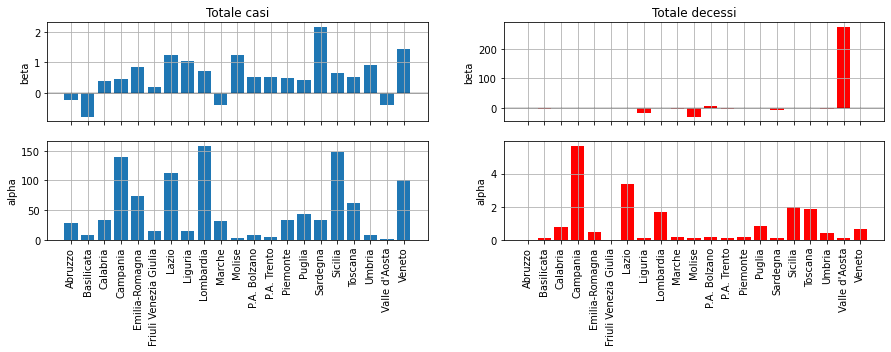

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(15, 4), sharex=True)

ax[0,0].set_title("Totale casi")
ax[0,0].bar(
    growth_df.index,
    growth_df[('totale_casi', 'beta')].values.astype(float)
)
ax[0,0].axhline(0, c='k', alpha=.2)
ax[0,0].set_ylabel('beta')
ax[0,0].grid()
ax[1,0].bar(
    growth_df.index,
    growth_df[('totale_casi', 'alpha')].values.astype(float)
)
ax[1,0].set_ylabel('alpha')
ax[1,0].grid()
ax[1,0].tick_params(axis='x', labelrotation=90)

ax[0,1].set_title("Totale decessi")
ax[0,1].bar(
    growth_df.index,
    growth_df[('deceduti', 'beta')].values.astype(float),
    color='r'
)
ax[0,1].grid()
ax[0,1].axhline(0, c='k', alpha=.2)
ax[0,1].set_ylabel('beta')
ax[1,1].bar(
    growth_df.index,
    growth_df[('deceduti', 'alpha')].values.astype(float),
    color='r'
)
ax[1,1].grid()
ax[1,1].set_ylabel('alpha')
ax[1,1].tick_params(axis='x', labelrotation=90)